<a href="https://colab.research.google.com/github/DrakeData/Image_Classification/blob/main/Image_Classification_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 8: Image Classification

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import os
import glob
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.image import imread
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.callbacks import CSVLogger
from keras.applications.vgg16 import VGG16
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.models import load_model
import shutil
import tensorflow as tf
from IPython.display import clear_output
import sys

## Ingest
Donwloading the data from Kaggle's API

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp './drive/MyDrive/Colab Notebooks/API Keys/kaggle.json' ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download dogs-vs-cats-redux-kernels-edition

100% 271M/271M [00:01<00:00, 230MB/s]
100% 271M/271M [00:01<00:00, 212MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 30.8MB/s]
 98% 532M/544M [00:03<00:00, 120MB/s]
100% 544M/544M [00:04<00:00, 140MB/s]


In [7]:
! unzip train.zip 

clear_output()

In [8]:
! unzip test.zip 

clear_output()

## EDA

### Image Sample
First, let's take a quick look at some of the images.

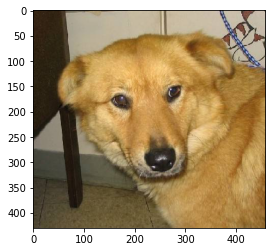

In [9]:
# Random image Check
filenames = os.listdir("./train")
sample = random.choice(filenames)
image = load_img("./train/"+sample)
plt.imshow(image);

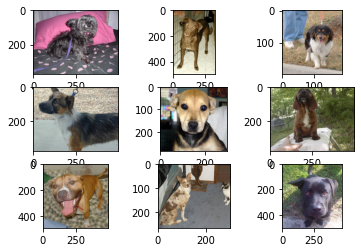

In [10]:
# Dog image comparison check

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = os.path.join('train', 'dog.'+str(i)+'.jpg')
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

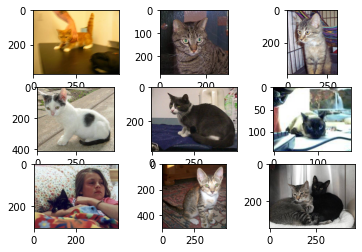

In [11]:
# Cat image comparison check

# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = os.path.join('train', 'cat.'+str(i)+'.jpg')
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()

Looking at the sample images, we can see that the photos come in many different shapes and sizes. There are also pictures that have more than one animal in them or that the cat/dog is not directly in the middle of the picture. We will have to keep this in mind for when we build our classification model as we will need to standardized the photo size.

### Total Count Check
Look to see how many dog/cat images we have in the training set.

In [12]:
filenames = os.listdir("./train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [13]:
df.head()

,filename,category
0,dog.3296.jpg,1
1,dog.12249.jpg,1
2,cat.10217.jpg,0
3,dog.3939.jpg,1
4,dog.3339.jpg,1


In [14]:
df['category'].value_counts()

1    12500
0    12500
Name: category, dtype: int64

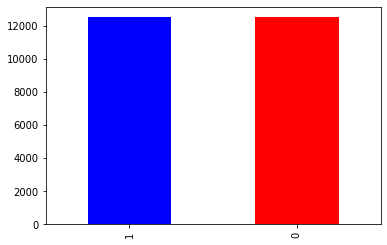

In [15]:
df['category'].value_counts().plot.bar(color=['blue', 'red']);

There is an equal amount of dog and cat images in our training set (12,500 each).

### Standardize Images
Before running the images through a model, we will want to standardize them to 200×200 pixels. This will improve the training speed of the model.

In [16]:
# create directories for standardized test and train images
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train', 'test']

for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs', 'cats']
	for labldir in labeldirs:
		newdir = os.path.join(dataset_home, subdir, labldir)
		os.makedirs(newdir, exist_ok=True)

In [17]:
# seed random number generator
random.seed(1)

# define ratio of pictures to use for validation
val_ratio = 0.25

# copy training dataset images into subdirectories
src_directory = 'train'

for file in os.listdir(src_directory):
	src = os.path.join(src_directory, file)
	dst_dir = 'train'
	if random.random() < val_ratio:
		dst_dir = 'test'
	if file.startswith('cat'):
		dst =  os.path.join(dataset_home, dst_dir, 'cats', file)
		shutil.copyfile(src, dst)
	elif file.startswith('dog'):
		dst = os.path.join(dataset_home, dst_dir, 'dogs', file)
		shutil.copyfile(src, dst)

## Models

### Model 1 - 1 Block VGG
This model will have one convolutional layer with 32 filters followed by a max pooling layer.

In [18]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model

In [19]:
# define model
model = define_model()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [20]:
# create data generator
datagen = ImageDataGenerator(rescale=1.0/255.0)

In [21]:
# prepare iterators
train = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
	class_mode='binary', batch_size=64, target_size=(200, 200))
test = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
	class_mode='binary', batch_size=64, target_size=(200, 200))

Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [22]:
# csv_logger = CSVLogger('drive/MyDrive/Colab Notebooks/Image_Classification/training.log', separator=',', append=False)
# model.fit_generator(train, steps_per_epoch=len(train), validation_data=test,
# validation_steps=len(test), epochs=20, verbose=0, callbacks=[csv_logger])

In [23]:
# # save model
# model.save(
#     'drive/MyDrive/Colab Notebooks/Image_Classification/model1.h5',
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True,
# )

In [24]:
# load in model
model = load_model('drive/MyDrive/Colab Notebooks/Image_Classification/model1.h5')

In [25]:
# evaluate model
_, acc = model.evaluate(test, steps=len(test), verbose=0)
print(f'Accuracy Score: {acc* 100.0}')

Accuracy Score: 91.13121032714844


The accuracy of this model is okay, with it being around 73%.

In [26]:
hist_df = pd.read_csv('drive/MyDrive/Colab Notebooks/Image_Classification/training.log')
hist_df.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.572124,0.680372,0.611296,0.645349
1,1,0.620955,0.637682,0.599714,0.650625
2,2,0.643793,0.622074,0.649056,0.620262
3,3,0.653955,0.608918,0.669998,0.598552
4,4,0.674065,0.594793,0.645090,0.612645


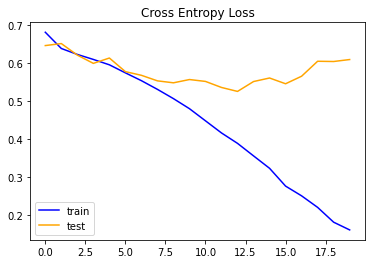

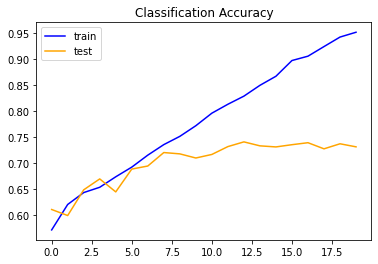

In [27]:
# plot loss
pyplot.title('Cross Entropy Loss')
pyplot.plot(hist_df['loss'], color='blue', label='train')
pyplot.plot(hist_df['val_loss'], color='orange', label='test')
pyplot.legend()
pyplot.show()

# plot accuracy
pyplot.title('Classification Accuracy')
pyplot.plot(hist_df['accuracy'], color='blue', label='train')
pyplot.plot(hist_df['val_accuracy'], color='orange', label='test')
pyplot.legend()
pyplot.show()

### Model 2 - 3 Block VGG
Similar to Model 1, except Model 2 has 3 blocks with 128 filters.

In [28]:
# define cnn model
def define_model2():
	model2 = Sequential()
	model2.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
	model2.add(MaxPooling2D((2, 2)))
	model2.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model2.add(MaxPooling2D((2, 2)))
	model2.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model2.add(MaxPooling2D((2, 2)))
	model2.add(Flatten())
	model2.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model2.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model2

In [29]:
# define model
# model2 = define_model2()

# csv_logger2 = CSVLogger('drive/MyDrive/Colab Notebooks/Image_Classification/training2.log', separator=',', append=False)
# model2.fit_generator(train, steps_per_epoch=len(train), validation_data=test,
# validation_steps=len(test), epochs=20, verbose=0, callbacks=[csv_logger2])

In [30]:
# # save model
# model2.save(
#     'drive/MyDrive/Colab Notebooks/Image_Classification/model2.h5',
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True,
# )

In [31]:
# load in model
model2 = load_model('drive/MyDrive/Colab Notebooks/Image_Classification/model2.h5')

# evaluate model
_, acc = model2.evaluate(test, steps=len(test), verbose=0)
print(f'Accuracy Score: {acc * 100.0}')

Accuracy Score: 94.36776041984558


In [32]:
hist_df2 = pd.read_csv('drive/MyDrive/Colab Notebooks/Image_Classification/training2.log')
hist_df2.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.591218,0.664095,0.624147,0.640005
1,1,0.659945,0.608293,0.633508,0.620773
2,2,0.701022,0.567958,0.730129,0.544906
3,3,0.733647,0.529969,0.732508,0.530689
4,4,0.754613,0.503044,0.756148,0.499449


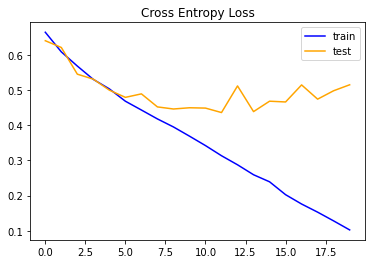

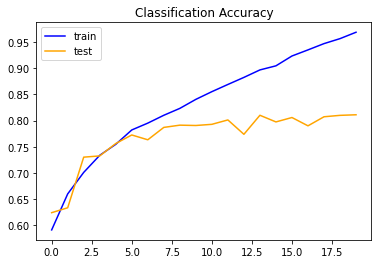

In [33]:
# plot loss
pyplot.title('Cross Entropy Loss')
pyplot.plot(hist_df2['loss'], color='blue', label='train')
pyplot.plot(hist_df2['val_loss'], color='orange', label='test')
pyplot.legend()
pyplot.show()

# plot accuracy
pyplot.title('Classification Accuracy')
pyplot.plot(hist_df2['accuracy'], color='blue', label='train')
pyplot.plot(hist_df2['val_accuracy'], color='orange', label='test')
pyplot.legend()
pyplot.show()

### Model 3 - Keras VGG16
We will be looking at Kera's VGG16 model that has pre-trained weights. More details on Kera's application can be [found here](https://keras.io/api/applications/#usage-examples-for-image-classification-models).

In [34]:
# define cnn model
def define_model3():
	# load model
	model3 = VGG16(include_top=False, input_shape=(224, 224, 3))
	# mark loaded layers as not trainable
	for layer in model3.layers:
		layer.trainable = False
	# add new classifier layers
	flat1 = Flatten()(model3.layers[-1].output)
	class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
	output = Dense(1, activation='sigmoid')(class1)
	# define new model
	model3 = Model(inputs=model3.inputs, outputs=output)
	# compile model
	opt = SGD(lr=0.001, momentum=0.9)
	model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
	return model3

In [35]:
# define model
model3 = define_model3()

# create data generator
datagen = ImageDataGenerator(featurewise_center=True)
# specify imagenet mean values for centering
datagen.mean = [123.68, 116.779, 103.939]
# prepare iterator
train2 = datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
  class_mode='binary', batch_size=64, target_size=(224, 224))
test2 = datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
  class_mode='binary', batch_size=64, target_size=(224, 224))

58900480/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 18697 images belonging to 2 classes.
Found 6303 images belonging to 2 classes.


In [36]:
# csv_logger3 = CSVLogger('drive/MyDrive/Colab Notebooks/Image_Classification/training3.log', separator=',', append=False)
# model3.fit_generator(train2, steps_per_epoch=len(train2), validation_data=test2,
# validation_steps=len(test2), epochs=20, verbose=0, callbacks=[csv_logger3])

In [37]:
# # save model
# model3.save(
#     'drive/MyDrive/Colab Notebooks/Image_Classification/model3.h5',
#     overwrite=True,
#     include_optimizer=True,
#     save_format=None,
#     signatures=None,
#     options=None,
#     save_traces=True,
# )

In [38]:
# load in model
model3 = load_model('drive/MyDrive/Colab Notebooks/Image_Classification/model3.h5')

# evaluate model
_, acc = model3.evaluate(test2, steps=len(test2), verbose=0)
print(f'Accuracy Score: {acc * 100.0}')

Accuracy Score: 99.4288444519043


Compared to the other 2 models, this has the highest accuracy score of around 97%.

In [39]:
hist_df3 = pd.read_csv('drive/MyDrive/Colab Notebooks/Image_Classification/training3.log')
hist_df3.head()

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.967000,0.197832,0.969538,0.079334
1,1,0.992566,0.022314,0.975567,0.074726
2,2,0.999144,0.004905,0.975726,0.098484
3,3,0.999840,0.001354,0.975884,0.106835
4,4,0.999786,0.001044,0.975884,0.111964


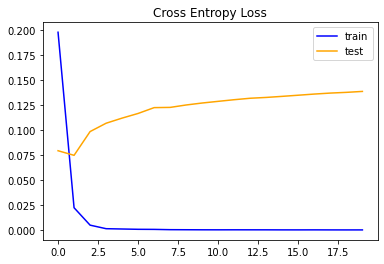

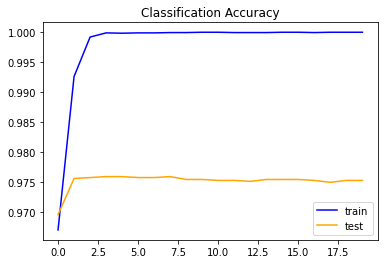

In [40]:
# plot loss
pyplot.title('Cross Entropy Loss')
pyplot.plot(hist_df3['loss'], color='blue', label='train')
pyplot.plot(hist_df3['val_loss'], color='orange', label='test')
pyplot.legend()
pyplot.show()

# plot accuracy
pyplot.title('Classification Accuracy')
pyplot.plot(hist_df3['accuracy'], color='blue', label='train')
pyplot.plot(hist_df3['val_accuracy'], color='orange', label='test')
pyplot.legend()
pyplot.show()

## Make Prediction
Using Model 3, we will make a prediction on the test images and submit our findings to Kaggle.

324.jpg


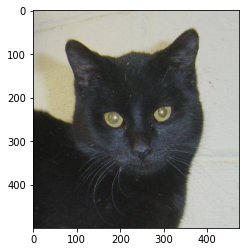

In [41]:
# Random image Check
filenames = os.listdir("./test")
sample = random.choice(filenames)
image = load_img("./test/"+sample)
print(sample)
plt.imshow(image);

In [42]:
# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(224, 224))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 224, 224, 3)
	# center pixel data
	img = img.astype('float32')
	img = img - [123.68, 116.779, 103.939]
	return img

In [43]:
test_dir = './test'
batch_size = 64
img_height = 224
img_width = 224

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  labels=None,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  interpolation='nearest',
  shuffle=False)

Found 12500 files belonging to 1 classes.


In [44]:
pred_labels = model3.predict(test_ds, batch_size=batch_size)
pred_str_labels = ['dog' if num > 0.5 else 'cat' for num in pred_labels]

In [45]:
test_filenames = os.listdir("./test")
submission_df = pd.read_csv('sample_submission.csv')
for i, fname in enumerate(test_filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    submission_df.at[index-1, 'label'] = pred_labels[index-1]
submission_df.to_csv('drive/MyDrive/Colab Notebooks/Image_Classification/submission.csv', index=False)
submission_df.head()

,id,label
0,1,1.000000e+00
1,2,0.000000e+00
2,3,4.225580e-11
3,4,1.000000e+00
4,5,1.000000e+00


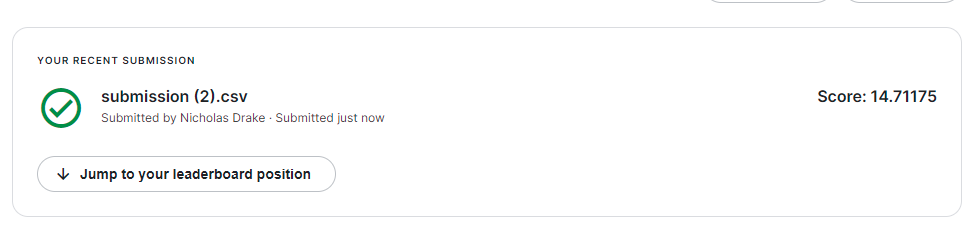